In [304]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [305]:
data = pd.read_csv('../Crypto_data/BITCOIN_Data.csv', date_parser = True)

In [306]:
data

,Datum,Zuletzt,Eröffn.,Hoch,Tief,Vol.,+/- %
0,08.12.2021,"50.497,1","50.596,6","50.799,1","50.090,9","48,86K","-0,19%"
1,07.12.2021,"50.595,2","50.547,4","51.918,6","50.070,9","56,29K","0,07%"
2,06.12.2021,"50.562,1","49.412,1","50.913,3","47.237,9","89,68K","2,34%"
3,05.12.2021,"49.405,5","49.196,4","49.689,3","47.797,8","72,03K","0,43%"
4,04.12.2021,"49.195,2","53.620,7","53.847,2","42.587,8","168,00K","-8,27%"
...,...,...,...,...,...,...,...
703,05.01.2020,"7.372,5","7.376,8","7.501,0","7.345,6","628,14K","-0,06%"
704,04.01.2020,"7.376,8","7.345,1","7.433,1","7.291,4","523,91K","0,46%"
705,03.01.2020,"7.343,1","6.967,1","7.402,9","6.884,1","936,29K","5,40%"
706,02.01.2020,"6.967,0","7.199,7","7.209,6","6.901,4","632,78K","-3,23%"


In [307]:
data.rename(columns={'Datum':'Date', 'Eröffn.':'Open', 'Hoch':'High',
                     'Tief':'Low', 'Vol.':'Volume', 'Zuletzt':'Close'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data.drop('+/- %', axis=1, inplace=True)
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

In [308]:
data

,Date,Close,Open,High,Low,Volume
0,2020-01-01,"7.199,8","7.196,4","7.259,4","7.180,0","420,28K"
1,2020-01-02,"6.967,0","7.199,7","7.209,6","6.901,4","632,78K"
2,2020-01-03,"7.343,1","6.967,1","7.402,9","6.884,1","936,29K"
3,2020-01-04,"7.376,8","7.345,1","7.433,1","7.291,4","523,91K"
4,2020-01-05,"7.372,5","7.376,8","7.501,0","7.345,6","628,14K"
...,...,...,...,...,...,...
703,2021-12-04,"49.195,2","53.620,7","53.847,2","42.587,8","168,00K"
704,2021-12-05,"49.405,5","49.196,4","49.689,3","47.797,8","72,03K"
705,2021-12-06,"50.562,1","49.412,1","50.913,3","47.237,9","89,68K"
706,2021-12-07,"50.595,2","50.547,4","51.918,6","50.070,9","56,29K"


In [309]:
for column in data.drop(columns=['Date', 'Volume']).columns:
    data[column] = [float(str(i).replace(",", "")) for i in data[column]]
    
data['Volume'] = [str(i).replace(",", "") for i in data['Volume']]
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [310]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

data['Volume'] = data['Volume'].apply(value_to_float)

In [311]:
data_training = data[data['Date'] < '2021-06-01'].copy()
data_test = data[data['Date'] > '2021-06-01'].copy()

In [312]:
training_data = data_training.drop(['Date'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,7.1964,7.2594,7.1800,7.1998,42028000.0
1,7.1997,7.2096,6.9014,6.9670,63278000.0
2,6.9671,7.4029,6.8841,7.3431,93629000.0
3,7.3451,7.4331,7.2914,7.3768,52391000.0
4,7.3768,7.5010,7.3456,7.3725,62814000.0


In [313]:
# MinMaxScaler is used to normalize the data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.04054556, 0.03181521, 0.0568834 , 0.04042926, 0.02062831],
       [0.04060175, 0.03097694, 0.05209629, 0.03646434, 0.0311182 ],
       [0.03664118, 0.03423068, 0.05179903, 0.04286987, 0.04610072],
       ...,
       [0.52528223, 0.53624806, 0.51195402, 0.50683217, 0.00780102],
       [0.50697441, 0.52213396, 0.50811884, 0.52502516, 0.00502429],
       [0.52493317, 0.54051679, 0.52138733, 0.55305553, 0.00638279]])

In [314]:
X_train = [] 
Y_train = []

In [315]:
training_data.shape[0]

517

In [316]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])   
    Y_train.append(training_data[i,0])

In [317]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(457, 60, 5)

In [318]:
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], len(X_train[0][0]))))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 50)            11200     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_17 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_18 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_18 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [319]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [320]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 50, validation_split = 0.1)

Epoch 1/20
9/9 [==============================] - 11s 410ms/step - loss: 0.0804 - val_loss: 0.0214
Epoch 2/20
9/9 [==============================] - 2s 264ms/step - loss: 0.0212 - val_loss: 0.0156
Epoch 3/20
9/9 [==============================] - 2s 266ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 4/20
9/9 [==============================] - 3s 299ms/step - loss: 0.0121 - val_loss: 0.0423
Epoch 5/20
9/9 [==============================] - 3s 304ms/step - loss: 0.0090 - val_loss: 0.0314
Epoch 6/20
9/9 [==============================] - 2s 264ms/step - loss: 0.0074 - val_loss: 0.0237
Epoch 7/20
9/9 [==============================] - 3s 332ms/step - loss: 0.0080 - val_loss: 0.0172
Epoch 8/20
9/9 [==============================] - 3s 270ms/step - loss: 0.0054 - val_loss: 0.0254
Epoch 9/20
9/9 [==============================] - 2s 227ms/step - loss: 0.0076 - val_loss: 0.0164
Epoch 10/20
9/9 [==============================] - 3s 282ms/step - loss: 0.0087 - val_loss: 0.0172
Epoch 11/20
9/9 [=

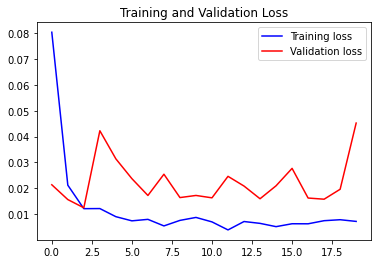

In [321]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [322]:
part_60_days = data_training.tail(60)
df = part_60_days.append(data_test, ignore_index = True)
df_backup = df.copy()
df = df.drop(['Date'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,58.7182,60.1349,58.4665,58.9773,7237000.0
1,58.9768,59.7705,56.9067,57.0599,6874000.0
2,57.0597,58.4648,56.4706,58.1999,5721000.0
3,58.2023,59.2051,56.8427,58.9934,5413000.0
4,59.1690,59.4870,57.4033,57.9963,7715000.0


In [323]:
inputs = scaler.transform(df)
inputs

array([[0.91782595, 0.92184478, 0.93812502, 0.92227527, 0.00345401],
       [0.92222922, 0.915711  , 0.91132341, 0.88961916, 0.00327482],
       [0.88958606, 0.89373274, 0.90383003, 0.90903501, 0.00270565],
       ...,
       [0.7593676 , 0.76662172, 0.74518712, 0.77895219, 0.00430851],
       [0.77869877, 0.78354349, 0.79386577, 0.77951593, 0.00266024],
       [0.77953652, 0.76469945, 0.79420942, 0.77784515, 0.00229346]])

In [324]:
X_test = []
Y_test = []

In [325]:
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])

X_test, Y_test = np.array(X_test), np.array(Y_test) 
#X_test.shape, Y_test.shape

In [326]:
Y_pred = model.predict(X_test)

In [327]:
scaler.scale_

array([1.70273630e-02, 1.68325515e-02, 1.71827211e-02, 1.70314520e-02,
       4.93641892e-10])

In [328]:
scale = 1/scaler.scale_[0]

In [329]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [330]:
df_backup_cut = df_backup[-190:]
df_backup_cut['Prediction'] = Y_pred
df_backup_cut['Actual'] = Y_test

C:\Users\Christian\AppData\Local\Temp\ipykernel_14876\2814265658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_14876\2814265658.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


In [331]:
Y_pred

array([[48.183186],
       [47.521847],
       [46.88286 ],
       [46.273018],
       [45.69592 ],
       [45.152706],
       [44.64229 ],
       [44.16035 ],
       [43.7047  ],
       [43.27605 ],
       [42.876205],
       [42.506126],
       [42.167435],
       [41.86434 ],
       [41.60167 ],
       [41.381676],
       [41.20361 ],
       [41.06307 ],
       [40.952415],
       [40.862858],
       [40.784462],
       [40.706055],
       [40.619606],
       [40.52084 ],
       [40.407623],
       [40.277374],
       [40.13088 ],
       [39.97187 ],
       [39.8063  ],
       [39.63988 ],
       [39.476707],
       [39.31913 ],
       [39.168682],
       [39.027878],
       [38.897926],
       [38.779156],
       [38.671516],
       [38.573257],
       [38.48249 ],
       [38.397705],
       [38.31828 ],
       [38.24346 ],
       [38.172207],
       [38.10202 ],
       [38.0311  ],
       [37.95706 ],
       [37.877865],
       [37.792202],
       [37.699535],
       [37.59811 ],


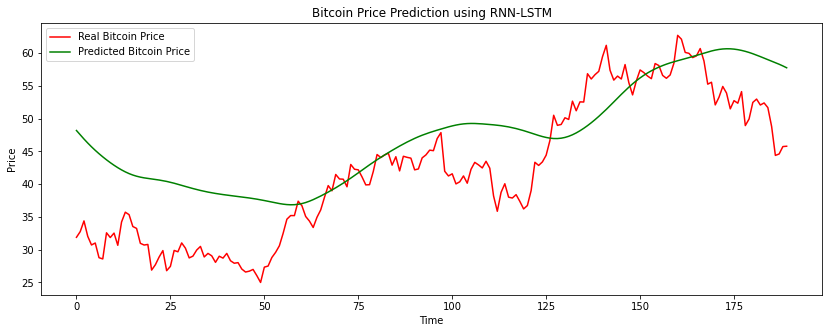

In [332]:
plt.figure(figsize=(14,5))

plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [333]:
df_backup_cut

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,36.6877,38.1999,35.9811,37.5558,9689000.0,48.183186,31.8725
61,2021-06-03,37.5557,39.4623,37.1936,39.1873,10644000.0,47.521847,32.7405
62,2021-06-04,39.1914,39.2554,35.6599,36.8513,12771000.0,46.882858,34.3762
63,2021-06-05,36.8412,37.8876,34.8320,35.5200,10148000.0,46.273018,32.0260
64,2021-06-06,35.5187,36.4340,35.2653,35.8154,6220000.0,45.695919,30.7035
...,...,...,...,...,...,...,...,...
245,2021-12-04,53.6207,53.8472,42.5878,49.1952,16800000.0,58.777512,48.8055
246,2021-12-05,49.1964,49.6893,47.7978,49.4055,7203000.0,58.545250,44.3812
247,2021-12-06,49.4121,50.9133,47.2379,50.5621,8968000.0,58.302505,44.5969
248,2021-12-07,50.5474,51.9186,50.0709,50.5952,5629000.0,58.042931,45.7322


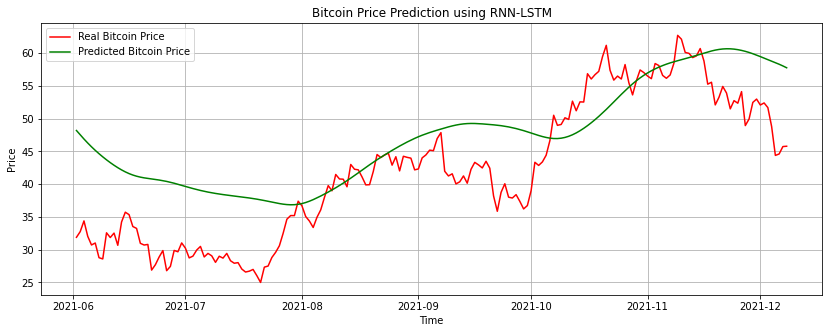

In [334]:
x = df_backup_cut['Date']
y1 = df_backup_cut['Prediction']
y2 = df_backup_cut['Actual']

fig, ax = plt.subplots(figsize=(14,5))

curr = 'Bitcoin'

ax.plot(x,y2, color = 'red', label = 'Real '+ curr + ' Price')
ax.plot(x,y1, color = 'green', label = 'Predicted '+ curr + ' Price')

ax.set_title('Bitcoin Price Prediction using RNN-LSTM')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
ax.grid()

plt.show()

In [335]:
data

,Date,Open,High,Low,Close,Volume
0,2020-01-01,7.1964,7.2594,7.1800,7.1998,42028000.0
1,2020-01-02,7.1997,7.2096,6.9014,6.9670,63278000.0
2,2020-01-03,6.9671,7.4029,6.8841,7.3431,93629000.0
3,2020-01-04,7.3451,7.4331,7.2914,7.3768,52391000.0
4,2020-01-05,7.3768,7.5010,7.3456,7.3725,62814000.0
...,...,...,...,...,...,...
703,2021-12-04,53.6207,53.8472,42.5878,49.1952,16800000.0
704,2021-12-05,49.1964,49.6893,47.7978,49.4055,7203000.0
705,2021-12-06,49.4121,50.9133,47.2379,50.5621,8968000.0
706,2021-12-07,50.5474,51.9186,50.0709,50.5952,5629000.0


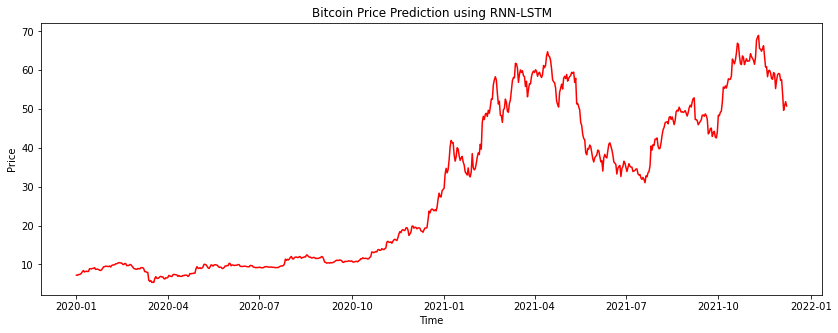

In [336]:
x = data['Date']
y1 = data['High']
#y2 = df_backup_cut['Actual']

fig, ax = plt.subplots(figsize=(14,5))

ax.plot(x,y1, color = 'red', label = 'Real Bitcoin Price')
#ax.plot(x,y2, color = 'green', label = 'Predicted Bitcoin Price')

ax.set_title('Bitcoin Price Prediction using RNN-LSTM')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

plt.show()